In [1]:
import numpy as np
import pandas as pd
import os
import h5py as h5
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class FileReader(object):
    def __init__(self, path, class_labels=['city','interurban','highway']):
        self.class_labels = class_labels
        self.path_to_filelist(path)
            
    def path_to_filelist(self, path):
        self.file_list = []
        if os.path.isfile(path=path):
            self.file_list.append(path)
        elif os.path.isdir(path):
            for fn in os.listdir(path):
                self.file_list.append(path + fn)
    
    def get_label_percentage(self,filename, b_train=False, pred_key='test_enhanced_pred', label_key = 'test_enhanced_label'):
        with h5.File(filename, 'r') as hf:    
            prediction_vecs = np.array(hf[pred_key])
            label = np.argmax(hf[label_key], axis=1)
            class_labels = np.array([self.class_labels[l] for l in label])
            
            result = {}
            for cl_label in self.class_labels:
                result[cl_label] = np.sum(class_labels==cl_label)/len(class_labels)
                
        return result        
    
    def create_file_frame(self, filename, seed, vocab, approach='nengo', data=[], b_train=False):
        with h5.File(filename, 'r') as hf:
            pred_key='test_enhanced_pred'
            label_key = 'test_enhanced_label'
            if b_train:
                pred_key='train_pred'
                label_key='train_label'
                
            prediction_vecs = np.array(hf[pred_key])
            label = np.argmax(hf[label_key], axis=1)
            prediction = np.argmax(hf[pred_key], axis=1)
            l = np.min([len(label), len(prediction)])
            b_prediction = label[:l] == prediction[:l]
            confidence = prediction_vecs[prediction]
            
            for i in np.arange(l):
                
                dat_dict = dict(true_label=self.class_labels[label[i]], 
                            prediction_label=self.class_labels[prediction[i]], 
                            b_correct_prediction=b_prediction[i],
                            confidence=confidence[i][prediction[i]],
                            seed=seed,
                            vocab=vocab,
                            approach=approach)

                data.append(dat_dict)

        return pd.DataFrame(data), data
    
    def create_plot_frame_from_file_frame(self, file_frame):
        data = []
        for app in np.unique(file_frame['approach']):
            for vocab in np.unique(file_frame.query('approach == "%s"'%app)['vocab']):
                for seed in np.unique(file_frame.query('approach == "%s" and vocab == "%s"'%(app, vocab))['seed']):
                    df = file_frame.query('approach == "%s" and vocab == "%s" and seed == %i'%(app, vocab, seed))
                    dat_dict = dict(
                        approach=app,
                        vocab=vocab,
                        seed=seed,
                        percentage=100*np.sum(df['b_correct_prediction'])/len(df['b_correct_prediction']),
                        label='total'
                        )
                    data.append(dat_dict)
                    
                    for label in self.class_labels:
                        dat_dict = dict(
                            approach=app,
                            vocab=vocab,
                            seed=seed,
                            percentage=100*np.sum(df.query('true_label=="%s"'%label)['b_correct_prediction'])/len(df.query('true_label=="%s"'%label)['b_correct_prediction']),
                            label=label
                        )
                        data.append(dat_dict)
                        
        return pd.DataFrame(data)
                    

In [3]:
fr = FileReader(path='/media/flo/LACIE_HD1/data/original/train_mem_dir_pos_eqt_hr.h5')

In [4]:
data = []
for i, fn in enumerate(fr.file_list):
    df, data = fr.create_file_frame(fn, seed=i, vocab='random_512', approach='nengo', data=data, b_train=False)

In [5]:
fr.path_to_filelist(path='/media/flo/LACIE_HD1/data/keras_mem_dir_pos_eqt.h5')
for i, fn in enumerate(fr.file_list):
    df, data = fr.create_file_frame(fn, seed=i, vocab='random_512', approach='keras', data=data, b_train=False)

In [6]:
fr = FileReader(path='/media/flo/LACIE_HD1/data/512D/')
for i, fn in enumerate(fr.file_list):
    df, data = fr.create_file_frame(fn, seed=i, vocab='random_512', approach='nengo improved', data=data, b_train=False)

In [7]:
plot_df = fr.create_plot_frame_from_file_frame(file_frame=df)

In [8]:
import csv
cnn_data = []
with open('/home/flo/git/diss/deep_context_classification/results_early.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for ind, row in enumerate(reader):
        if ind > 3: 
            break
        print(row[0][-6:-1])
        if ind > 0:
            print(row[0].split('(')[1].split(')')[0])
            dat_dict = dict(
                approach='CNN',
                vocab='images',
                seed=0,
                percentage=np.float(row[0][-6:-1]),
                label=row[0].split('(')[1].split(')')[0]
            )
            cnn_data.append(dat_dict) 
        else:
            dat_dict = dict(
                approach='CNN',
                vocab='images',
                seed=0,
                percentage=np.float(row[0][-6:-1]),
                label='total'
            )
            cnn_data.append(dat_dict)       

35.72
90.75
city
19.24
interurban
10.51
highway


In [9]:
plot_df = plot_df.append(pd.DataFrame(cnn_data))

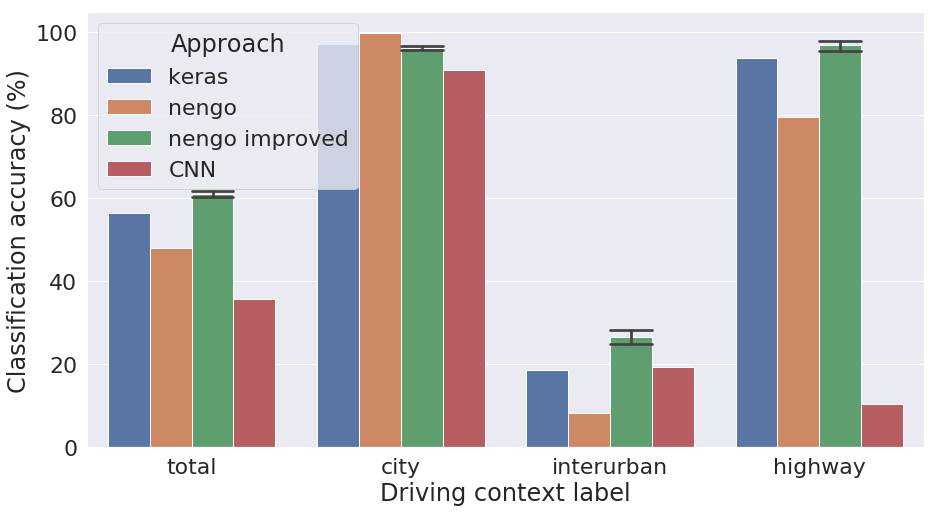

In [10]:
sns.set_style("darkgrid")
sns.set(font_scale=2)
fig = plt.figure(figsize=(15,8))
ax = sns.barplot(x='label', y='percentage', hue='approach', data=plot_df, capsize=0.2)
# ax.set_title('distances to closest vehicle')
# ax2[1].set_title('distances to ego-vehicle')
ax.set_xlabel('Driving context label')
ax.set_ylabel('Classification accuracy (%)')
ax.legend(title='Approach', frameon=True)
# ax.set_ylim([20,100])
plt.show()

In [11]:
human_data = []
p = '/media/flo/LACIE_HD1/training_data/train/'
fl = []
for fn in os.listdir(p):
    if 'human' in fn and 'juergen' not in fn:
        fl.append(p + fn)
print(fl)

map_d = dict(performance_total='total', performance_highway='highway', performance_inter='interurban', performance_city='city')
for i, fn in enumerate(fl):
    with h5.File(fn, 'r') as hf:
        for k,v in list(map_d.items()):
            dat_dict = dict(
                approach='human',
                vocab='random_512',
                seed=i,
                data_set='train',
                percentage=100*np.sum(hf[k]),
                label=v
                )
            human_data.append(dat_dict)

['/media/flo/LACIE_HD1/training_data/train/train_mem_dir_hr_human_perf_subset_50.h5', '/media/flo/LACIE_HD1/training_data/train/train_mem_dir_hr_human_perf_subset_50_christoph.h5']


In [12]:

p = '/media/flo/LACIE_HD1/training_data/test_enhanced/'
fl = []
for fn in os.listdir(p):
    if 'human' in fn and 'juergen' not in fn and '50' in fn:
        fl.append(p + fn)
print(fl)
map_d = dict(performance_total='total', performance_highway='highway', performance_inter='interurban', performance_city='city')
for i, fn in enumerate(fl):
    with h5.File(fn, 'r') as hf:
        for k,v in list(map_d.items()):
            dat_dict = dict(
                approach='human',
                vocab='random_512',
                seed=i,
                data_set='test',
                percentage=100*np.sum(hf[k]),
                label=v
                )
            human_data.append(dat_dict)

['/media/flo/LACIE_HD1/training_data/test_enhanced/train_mem_dir_hr_human_perf_subset_50.h5', '/media/flo/LACIE_HD1/training_data/test_enhanced/train_mem_dir_hr_human_perf_subset_50_christoph.h5']


In [13]:
human_df = pd.DataFrame(human_data)

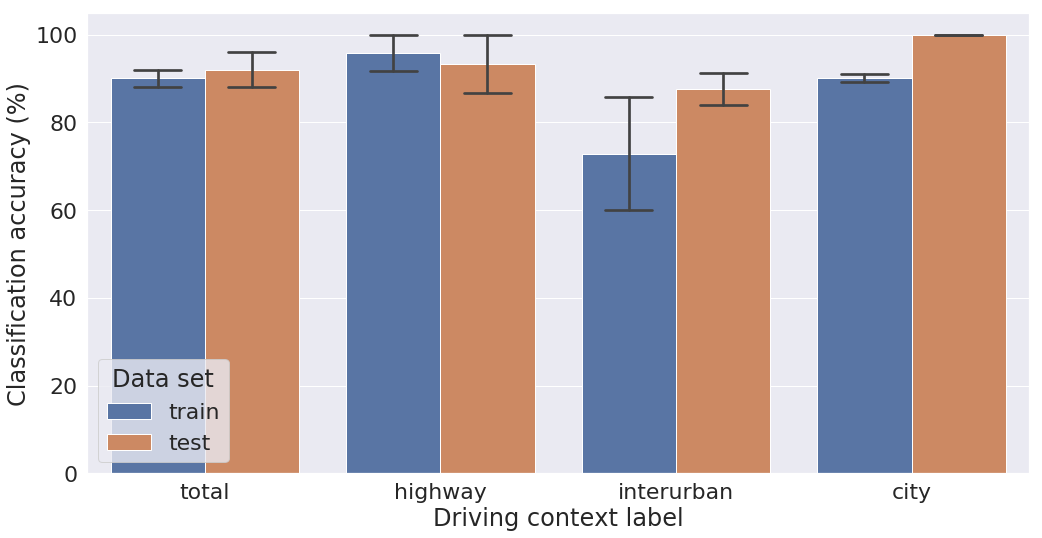

In [14]:
fig = plt.figure(figsize=(15,8))
ax = sns.barplot(x='label', y='percentage', hue='data_set', data=human_df, capsize=0.2)
# ax.set_title('distances to closest vehicle')
# ax2[1].set_title('distances to ego-vehicle')
ax.set_xlabel('Driving context label')
ax.set_ylabel('Classification accuracy (%)')
ax.legend(title='Data set', frameon=True)
# ax.set_ylim([20,100])
plt.tight_layout()
plt.savefig('/home/flo/git/diss/thesis/imgs/context_class_human_train_test.eps', dpi=1200)
plt.show()

In [15]:
human_data = []
p = '/media/flo/LACIE_HD1/training_data/test_enhanced/'
fl = []
for fn in os.listdir(p):
    if 'human' in fn and 'juergen' not in fn and '50' in fn:
        fl.append(p + fn)
print(fl)
map_d = dict(performance_total='total', performance_highway='highway', performance_inter='interurban', performance_city='city')
for i, fn in enumerate(fl):
    with h5.File(fn, 'r') as hf:
        for k,v in list(map_d.items()):
            dat_dict = dict(
                approach='human',
                vocab='random_512',
                seed=i,
                percentage=100*np.sum(hf[k]),
                label=v
                )
            human_data.append(dat_dict)

['/media/flo/LACIE_HD1/training_data/test_enhanced/train_mem_dir_hr_human_perf_subset_50.h5', '/media/flo/LACIE_HD1/training_data/test_enhanced/train_mem_dir_hr_human_perf_subset_50_christoph.h5']


In [16]:
test_df = plot_df.copy()

In [17]:
test_df = test_df.append(pd.DataFrame(human_data))

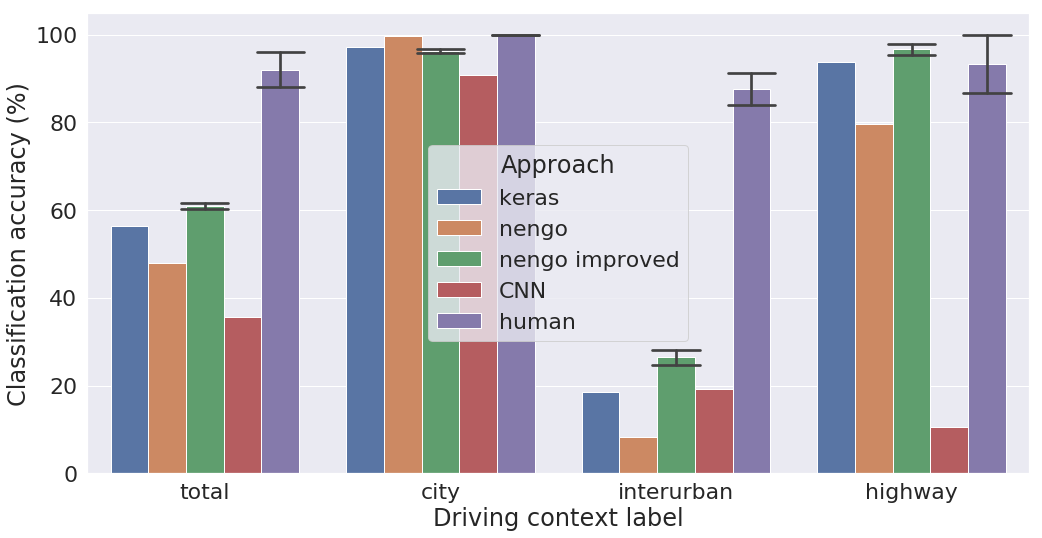

In [18]:
sns.set_style("darkgrid")
sns.set(font_scale=2)
fig = plt.figure(figsize=(15,8))
ax = sns.barplot(x='label', y='percentage', hue='approach', data=test_df, capsize=0.2)
# ax.set_title('distances to closest vehicle')
# ax2[1].set_title('distances to ego-vehicle')
ax.set_xlabel('Driving context label')
ax.set_ylabel('Classification accuracy (%)')
ax.legend(title='Approach', frameon=True)
# ax.set_ylim([20,100])
plt.tight_layout()
plt.savefig('/home/flo/git/diss/thesis/imgs/context_class_approaches.eps', dpi=1200)
plt.show()

In [19]:
test_df

,approach,label,percentage,seed,vocab
0,keras,total,56.373942,0,random_512
1,keras,city,97.066624,0,random_512
2,keras,interurban,18.620327,0,random_512
3,keras,highway,93.732008,0,random_512
4,nengo,total,48.012020,0,random_512
5,nengo,city,99.742827,0,random_512
6,nengo,interurban,8.169823,0,random_512
7,nengo,highway,79.518050,0,random_512
8,nengo improved,total,62.604134,0,random_512
9,nengo improved,city,96.437756,0,random_512


In [94]:
dic = fr.get_label_percentage(filename='/media/flo/LACIE_HD1/data/original/train_mem_dir_pos_eqt_hr.h5')
dic

{'city': 0.23333505229551774,
 'highway': 0.25894133807141817,
 'interurban': 0.5077236096330641}

In [95]:
dic = fr.get_label_percentage(filename='/media/flo/LACIE_HD1/data/original/train_mem_dir_pos_eqt_hr.h5', pred_key='train_pred', label_key='train_label')
dic

{'city': 0.5362659983036795,
 'highway': 0.2746006181722305,
 'interurban': 0.18913338352408998}

In [96]:
dic = fr.get_label_percentage(filename='/media/flo/LACIE_HD1/data/original/train_mem_dir_pos_eqt_hr.h5', pred_key='test_pred', label_key='test_label')
dic

{'city': 0.47314825349869155,
 'highway': 0.45376038229605187,
 'interurban': 0.07309136420525657}